## Setup

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import colors
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
from qutip.qip.operations import s_gate
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import matplotlib as mpl

In [2]:
# colors for plots to stay within paper pallete 
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

#### Define SiVs 

In [3]:
# Create SiVs, all numbers in MHz:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

## Setup single Node experiments in B16

In [4]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge
# Create Simulation:
sim = BlindComputing(b16_network)

In [5]:
# Setup efficiencies

b16_network.fibercoupling_eff = 0.6
b16_network.tdi_eff = 0.35*0.3
b16_network.snspd_eff = 0.9
b16_network.detection_eff
b16_network.detection_eff_reset()
print('Detection efficientvy is = ', b16_network.detection_eff)

Detection efficientvy is =  0.0567


#### MW gates

In [6]:
# gate fidelities

b16_mwfid = 0.99
g12_mwfid = 1

#### Move the SiV to the desired contrast point

In [7]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378


## B16 single qubit rotations

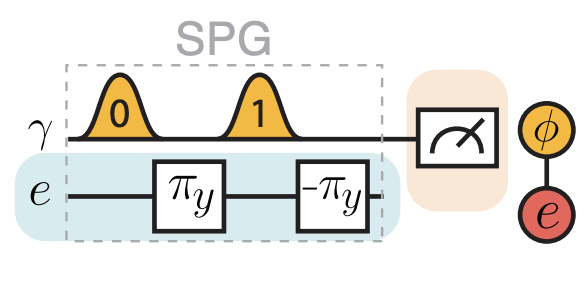

In [8]:
Image(filename='FiguresJupyter/SingleQubit_rotation.png')

In [22]:
## the original parameters
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real' set by the cavity-QED parameters
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.05

In [9]:
## plating with different parameters to get the nagative offset of the server state
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real' set by the cavity-QED parameters
                'tdinoise': 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.05

In [10]:
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0

In [50]:
cluster_state_length = 1
n_rounds = 100

rates_apd1_apd2 = np.empty((0, 2), dtype=float)
rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)
nxnynz_cl_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
nxnynz_s_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
for j in range(len(phi1)):
    rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
    rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
    rho_click = np.empty((0, 1), dtype=int)
    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    nxnynz_cl_array =  np.empty((0, 3), dtype=float)
    nxnynz_s_array =  np.empty((0, 3), dtype=float)
    for i in range(n_rounds): 
        if i%100 == 0:
            print(i)
        rho_init_xp = sim.single_node_electron_exp(rho_ideal_Xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_n_item_s = rho_init_xp[0]
        rho_n_item_cl = (qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))
        rho_n_array_s = np.vstack([rho_n_array_s, [rho_n_item_s]])
        rho_n_array_cl = np.vstack([rho_n_array_cl, [rho_n_item_cl]])
        nxnynz_cl = calculate_bloch_components(rho_n_item_cl)
        nxnynz_s = calculate_bloch_components(rho_n_item_s)
        nxnynz_cl_array =  np.vstack([nxnynz_cl_array, [nxnynz_cl]])
        nxnynz_s_array =  np.vstack([nxnynz_s_array, [nxnynz_s]])
    nxnynz_cl_phi_array =  np.vstack([nxnynz_cl_phi_array, [nxnynz_cl_array]])
    nxnynz_s_phi_array =  np.vstack([nxnynz_s_phi_array, [nxnynz_s_array]])
    mean_cl_nxnynz = np.mean(nxnynz_cl_array, axis =0)
    std_cl_nxnynz = np.std(nxnynz_cl_array, axis =0)/np.sqrt(n_rounds)
    mean_s_nxnynz = np.mean(nxnynz_s_array, axis =0)
    std_s_nxnynz = np.std(nxnynz_s_array, axis =0)/np.sqrt(n_rounds)
    print(mean_cl_nxnynz, std_cl_nxnynz)
    print(mean_s_nxnynz, std_s_nxnynz)
    rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

    rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
    rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])

Phi angle =  0
0
[ 0.91781155  0.08416893 -0.01857793] [0.00755834 0.00321399 0.03183244]
[ 0.46734203  0.01666539 -0.01857793] [0.07935252 0.00885418 0.03183244]
Phi angle =  0.7853981633974483
0
[0.55873522 0.71437125 0.02296606] [0.0199728  0.01645016 0.02529669]
[ 0.25492822 -0.06014463  0.02296606] [0.05358059 0.07305954 0.02529669]
Phi angle =  1.5707963267948966
0
[-0.09768679  0.89922632  0.00394182] [0.03192788 0.00374198 0.01845068]
[ 0.31256832 -0.00453413  0.00394182] [0.01173996 0.08999931 0.01845068]
Phi angle =  2.356194490192345
0
[-0.70765998  0.56557238 -0.00442542] [0.01455575 0.01631475 0.0295207 ]
[ 0.31748105 -0.01630183 -0.00442542] [0.06489803 0.05884076 0.0295207 ]


In [27]:
fid_err_phi =  np.empty((0, 2), dtype=float)
fid_ave_phi =  np.empty((0, 2), dtype=float)
for j in range(len(phi1)):
    U = rz(phi1[j])
    el_rho_final_ideal = U*rho_ideal_Xp*U.dag()
    fid_n =  np.empty((0, 2), dtype=float)
    for k in range(n_rounds):
        fid = (qt.fidelity(qt.Qobj(rho_phi_n_array_cl[j][k]), el_rho_final_ideal))**2
        fid_n = np.append(fid_n, fid)
    fid_ave = np.mean(fid_n, axis = 0)
    # this is only the variability of the measurement
    fid_ave_std = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))
    fid_ave_phi = np.append(fid_ave_phi, fid_ave)
    fid_err_phi = np.append(fid_err_phi, fid_ave_std)

In [28]:
print(np.mean(nxnynz_cl_phi_array, axis = 1))
print(np.std(nxnynz_cl_phi_array, axis = 1)/np.sqrt(n_rounds))
print(np.mean(nxnynz_s_phi_array, axis = 1))
print(np.std(nxnynz_s_phi_array, axis = 1)/np.sqrt(n_rounds))

[[ 0.92337941 -0.08821863 -0.02500928]
 [ 0.70922567  0.5762673  -0.04972562]
 [ 0.14311316  0.89283098  0.00336878]
 [-0.58944947  0.69026763 -0.0647741 ]]
[[0.00651809 0.00340849 0.02984546]
 [0.01419838 0.01694448 0.02614766]
 [0.03084069 0.00379971 0.02042899]
 [0.0198926  0.01678698 0.0245325 ]]
[[ 0.36006486 -0.00442508 -0.02500928]
 [ 0.2741785  -0.03622671 -0.04972562]
 [ 0.32057542  0.16761194  0.00336878]
 [ 0.32376775 -0.00528065 -0.0647741 ]]
[[0.08527786 0.00944708 0.02984546]
 [0.0669318  0.05995692 0.02614766]
 [0.0113259  0.08777797 0.02042899]
 [0.05312218 0.07103674 0.0245325 ]]


In [29]:
fid = np.mean(fid_ave_phi, axis = 0)
fiderr = np.sqrt(np.sum(fid_err_phi**2)/len(fid_err_phi))
print('Fidelity over phi = ', fid, "+-",  fiderr)

Fidelity over phi =  0.9537609855385365 +- 0.0028226669762793084


#### Blindness

In [31]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.mean(nxnynz_s_phi_array, axis =1)
std_nxnynz = np.std(nxnynz_s_phi_array, axis =1)/np.sqrt(n_rounds)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.mean(rho_phi_n_array_s, axis = 1)
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]

hv_std = holevo_bound_uncertainty_1q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


Holevo bound is =  0.004215816292248653 0.010692613022173022


### Create a plot of a rotation as a function of phi

In [11]:
phi1 = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, 8*np.pi/8]
phi2 = 0
phi3 = 0
cluster_state_length = 1
n_rounds = 100

rates_apd1_apd2 = np.empty((0, 2), dtype=float)
rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)
nxnynz_cl_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
nxnynz_s_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
for j in range(len(phi1)):
    rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
    rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
    rho_click = np.empty((0, 1), dtype=int)
    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    nxnynz_cl_array =  np.empty((0, 3), dtype=float)
    nxnynz_s_array =  np.empty((0, 3), dtype=float)
    for i in range(n_rounds): 
        rho_init_xp = sim.single_node_electron_exp(rho_ideal_Xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_n_item_s = rho_init_xp[0]
        rho_n_item_cl = (qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))
        rho_n_array_s = np.vstack([rho_n_array_s, [rho_n_item_s]])
        rho_n_array_cl = np.vstack([rho_n_array_cl, [rho_n_item_cl]])
        nxnynz_cl = calculate_bloch_components(rho_n_item_cl)
        nxnynz_s = calculate_bloch_components(rho_n_item_s)
        nxnynz_cl_array =  np.vstack([nxnynz_cl_array, [nxnynz_cl]])
        nxnynz_s_array =  np.vstack([nxnynz_s_array, [nxnynz_s]])
    nxnynz_cl_phi_array =  np.vstack([nxnynz_cl_phi_array, [nxnynz_cl_array]])
    nxnynz_s_phi_array =  np.vstack([nxnynz_s_phi_array, [nxnynz_s_array]])
    mean_cl_nxnynz = np.mean(nxnynz_cl_array, axis =0)
    std_cl_nxnynz = np.std(nxnynz_cl_array, axis =0)/np.sqrt(n_rounds)
    mean_s_nxnynz = np.mean(nxnynz_s_array, axis =0)
    std_s_nxnynz = np.std(nxnynz_s_array, axis =0)/np.sqrt(n_rounds)
    print(mean_cl_nxnynz, std_cl_nxnynz)
    print(mean_s_nxnynz, std_s_nxnynz)
    rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

    rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
    rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])

Phi angle =  0
[0.90300405 0.09249471 0.04188623] [0.01282242 0.00358244 0.03298805]
[ 0.26691124 -0.00389801  0.04188623] [0.08721331 0.00991134 0.03298805]
Phi angle =  0.39269908169872414
[ 0.8162666   0.41814553 -0.03355585] [0.01067838 0.01368553 0.02899118]
[ 0.33264976  0.01596901 -0.03355585] [0.07530193 0.04396817 0.02899118]
Phi angle =  0.7853981633974483
[ 0.57570516  0.70043755 -0.01746696] [0.01974295 0.01651973 0.02580765]
[ 0.29186239 -0.0189852  -0.01746696] [0.05340704 0.07194043 0.02580765]
Phi angle =  1.1780972450961724
[ 0.31915413  0.84521336 -0.01606401] [0.02890934 0.00900718 0.02202392]
[ 0.35969376  0.17210517 -0.01606401] [0.02367589 0.08323932 0.02202392]
Phi angle =  1.5707963267948966
[-0.0514899   0.89349775 -0.05598155] [0.03209528 0.00427726 0.02169419]
[ 0.3082094   0.06869132 -0.05598155] [0.01032903 0.08918796 0.02169419]
Phi angle =  1.9634954084936207
[-0.41841928  0.79664118 -0.0205084 ] [0.02622359 0.01406129 0.02379298]
[ 0.29563284  0.02413492

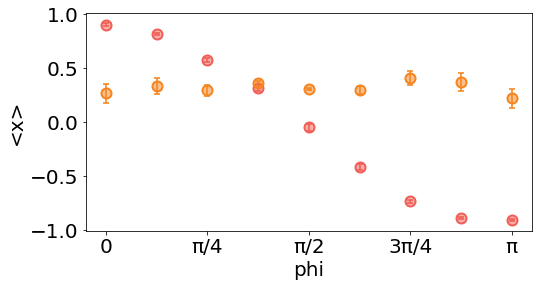

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Assuming phi1, c1, c2, nxnynz_cl_phi_array, nxnynz_s_phi_array, and n_rounds are defined elsewhere

x_mean_cl = np.mean(nxnynz_cl_phi_array, axis=1)
y_std_cl = np.std(nxnynz_cl_phi_array, axis=1) / np.sqrt(n_rounds)

x_mean_s = np.mean(nxnynz_s_phi_array, axis=1)
y_std_s = np.std(nxnynz_s_phi_array, axis=1) / np.sqrt(n_rounds)

# Sample data
x = phi1
y_cl = x_mean_cl[:, 0]
yerr_cl = y_std_cl[:, 0]  # Error values

y_s = x_mean_s[:, 0]
yerr_s = y_std_s[:, 0]    # Error values

# Define colors with alpha values
facecolor_cl = colors.to_rgba(c1, alpha=0.5)
edgecolor_cl = colors.to_rgba(c1, alpha=1.0)
errorbar_color_cl = colors.to_rgba(c1, alpha=0.8)

facecolor_s = colors.to_rgba(c2, alpha=0.5)
edgecolor_s = colors.to_rgba(c2, alpha=1.0)
errorbar_color_s = colors.to_rgba(c2, alpha=0.8)

# Create a new figure with specified size
plt.figure(figsize=(8, 4))  # Width and height in inches

# Create the error bar plot
plt.errorbar(
    x, y_cl, yerr=yerr_cl,
    fmt='o',
    markersize=10,
    markerfacecolor=facecolor_cl,
    markeredgecolor=edgecolor_cl,
    ecolor=errorbar_color_cl,
    capsize=3,
    elinewidth=2,
    markeredgewidth=2
)

plt.errorbar(
    x, y_s, yerr=yerr_s,
    fmt='o',
    markersize=10,
    markerfacecolor=facecolor_s,
    markeredgecolor=edgecolor_s,
    ecolor=errorbar_color_s,
    capsize=3,
    elinewidth=2,
    markeredgewidth=2
)

# Customize the plot
plt.xlabel('phi', fontsize=20)
plt.ylabel('<x>', fontsize=20)
# plt.title('Scatter Plot with Error Bars')

# Set specific x and y ticks
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
y_ticks = [-1, -0.5, 0, 0.5, 1]

# Optionally, set custom labels for the ticks
x_tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
plt.xticks(x_ticks, x_tick_labels, fontsize=20)
plt.yticks(y_ticks, fontsize=20)

# Save the plot as a PNG file
plt.savefig('/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/SimulationCode/OutputFiles/BlindComputing/Fig1/Figures/1qubit_rot_vsPhi.png', dpi=400, bbox_inches='tight')

# Display the plot
plt.show()


## B16 universal single qubit rotations

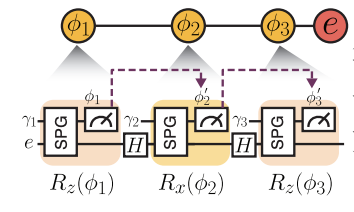

In [60]:
Image(filename='FiguresJupyter/SingleQubit_universal.png')

#### Identity

In [10]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
phi_array  = [0, 0, 0]

cluster_state_length = 3


In [11]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = psi_ideal_Yp

rho_n_array_cl_id = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_id = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_id =  np.empty((0, 3), dtype=float)
nxnynz_s_array_id =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.single_qubit_universal_blind_gate_with_feedback(rho_ideal_Yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_id = np.vstack([rho_n_array_s_id, [rho_s]])
    rho_n_array_cl_id = np.vstack([rho_n_array_cl_id, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_id = np.vstack([nxnynz_cl_array_id, [nxnynz_cl]])
    nxnynz_s_array_id = np.vstack([nxnynz_s_array_id, [nxnynz_s]])
nxnynz_tot_cl_id = np.mean(nxnynz_cl_array_id, axis = 0)
nxnynz_tot_s_id = np.mean(nxnynz_s_array_id, axis = 0)
nxnynz_tot_std_cl_id = np.std(nxnynz_cl_array_id, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_id = np.std(nxnynz_s_array_id, axis = 0)/np.sqrt(n_rounds)

fid_ave_id = np.mean(fid_n, axis = 0)
fid_ave_std_id = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_id)
print(nxnynz_tot_std_cl_id)

print(nxnynz_tot_s_id)
print(nxnynz_tot_std_s_id)

print("Fidelity of a universal Identity gate = ", fid_ave_id, "+-", fid_ave_std_id)


[0.03344129 0.07312211 0.07204078]
[0.08139116 0.09598656 0.0606977 ]
[-0.30497776  0.51101844 -0.02904986]
[0.05967761 0.02621043 0.06187954]
Fidelity of a universal Identity gate =  0.7555092223234113 +- 0.013105214756201846


##### FIdelity of Identity

In [12]:
U_transform_ztoy = qt.Qobj([[1, 1j], [1j, 1]]) / (2 ** 0.5)
print(U_transform_ztoy*rho_ideal_Yp*U_transform_ztoy.dag())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


In [14]:
def plot_from_rho_magic(rho, title, filename, color, client):

    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1})


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=15)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([2,2])

    for ii in range(2):
        for jj in range(2):
            hist[ii,jj] = np.abs(rho[ii,jj])

    dz = hist.ravel()

    cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!
    
    target = (116/255, 48/255, 98/255)
    start = (1,1,1)
    diff = np.array([1-116/255, 1-48/255, 1-98/255])
    diff = diff/np.max(diff)

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    max_height = 1  # get range of colorbars so we can normalize
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    hist = np.array([[0, 0],
                     [0, 1]])

    zpos_hist = np.abs(np.real(rho[:]))
    dz_hist = hist - np.abs(np.real(rho[:]))

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = zpos_hist.ravel()

    # Construct arrays with the dimensions for the 4 bars.
    dx = dy = 0.75 * np.ones_like(zpos)
    dz = hist.ravel()

    if client == True:
        hist = np.array([[0, 0],
                        [0, 1]])
    elif client == False:
        hist = np.array([[0.5, 0],
                        [0, 0.5]])

    dz = dz_hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1, edgecolor='grey', color=(0, 0, 1, 0))


    ax.plot([0.05,0.05],[0.05,0.05],[-0.01,1], color='k', linewidth=1)
    #ax.plot([0.0,0.0],[2.3,4.3],[0,0.5], color='k', linewidth=1.5)


    ax.set_zticks([0, 0.5, 1])
    ax.set_zlim([0,1])
    ax.set_zticklabels(["0", "", "1"])

    ax.set_xticks([0.5, 1.5])
    ax.set_xlim([0.09,2.2])
    # ax.set_xticklabels(["-TXT", "+TXT"])
    ax.set_yticks([0.5, 1.5])
    ax.set_ylim([0.09,2.2])
    # ax.set_yticklabels(["-TXT", "+TXT"])

    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.edge = 0

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
    ax.zaxis._axinfo["grid"]['linewidth'] =  1
    ax.zaxis._axinfo["tick"]['lenght'] =  0

    ax.xaxis.set_tick_params(length=0)
    ax.tick_params(color=(0,0,0,0))

    ax.w_zaxis.linewidth =  1
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    ax.set_title(title)


    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

In [88]:
def plot_from_rho_Identity(rho, title, filename, color, client):

    if client == True:
        target = (241/255, 95/255, 88/255)
        start = (1,1,1)
        diff = np.array([1-241/255, 1-95/255, 1-88/255])
        diff = diff/np.max(diff)

    elif client == False:
        target = (116/255, 48/255, 98/255)
        start = (1,1,1)
        diff = np.array([1-116/255, 1-48/255, 1-98/255])
        diff = diff/np.max(diff)

    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1})
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=15)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([2,2])

    for ii in range(2):
        for jj in range(2):
            hist[ii,jj] = np.abs(rho[ii,jj])
            # print(hist[ii,jj])

    dz = hist.ravel()

    cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    max_height = 1  # get range of colorbars so we can normalize
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    if client == True:
        print("TRue")
        hist = np.array([[0, 0],
                        [0, 1]])

    elif client == False:
        print("hi")
        hist = np.array([[0.5, 0],
                        [0, 0.5]])
    

    zpos_hist = np.abs(np.real(rho[:]))
    dz_hist = hist - np.abs(np.real(rho[:]))
    # print('zpos_hist', zpos_hist)
    # print('dz_hist', dz_hist)


    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = zpos_hist.ravel()

    # Construct arrays with the dimensions for the 4 bars.
    dx = dy = 0.75 * np.ones_like(zpos)
    dz = hist.ravel()

    dz = dz_hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1, edgecolor='grey', color=(0, 0, 1, 0))


    ax.plot([0.05,0.05],[0.05,0.05],[-0.01,1], color='k', linewidth=1)
    #ax.plot([0.0,0.0],[2.3,4.3],[0,0.5], color='k', linewidth=1.5)


    ax.set_zticks([0, 0.5, 1])
    ax.set_zlim([0,1])
    # ax.set_zticklabels(["0", "", "1"])

    ax.set_xticks([0.5, 1.5])
    ax.set_xlim([0.09,2.2])
    # ax.set_xticklabels(["$-Y$", "$+Y$"])

    ax.set_yticks([0.5, 1.5])
    ax.set_ylim([0.09,2.2])
    # ax.set_yticklabels(["$-Y$", "$+Y$"])

    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.edge = 0

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
    ax.zaxis._axinfo["grid"]['linewidth'] =  1
    ax.zaxis._axinfo["tick"]['lenght'] =  0

    ax.xaxis.set_tick_params(length=0)
    ax.tick_params(color=(0,0,0,0))

    ax.w_zaxis.linewidth =  1
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    ax.set_title(title)

    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

In [89]:
def plot_from_rho(rho, title, filename, color, ON):

    # not sensitive to imaginary elements of the density matrix
    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1.5})


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=25)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2, 3, 4])
    yedges = np.array([0, 1, 2, 3, 4])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([4,4])

    for ii in range(4):
        for jj in range(4):
            hist[ii,jj] = np.abs(np.abs(rho[ii,jj]))

    dz = hist.ravel()

    #cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!
    
    target = color
    start = (1,1,1)
    diff = np.array([1-target[0], 1-target[1], 1-target[2]])
    diff = diff/np.max(diff)

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    if ON:
        max_height = 0.5  # get range of colorbars so we can normalize
    else:
        max_height = 1.0
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    xpos_ori, ypos_ori, zpos_ori, dx_ori, dy_ori, dz_ori \
        = xpos, ypos, zpos, dx.copy(), dy.copy(), dz.copy()
#     ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1.5, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 3, 6])
    yedges = np.array([0, 3, 6])

    if ON:
        hist = 0.5*np.ones([2,2])


        zpos_hist = np.abs(np.real(rho[0:4:3,0:4:3]))
        dz_hist = hist - np.abs(np.real(rho[0:4:3,0:4:3]))

        # Construct arrays for the anchor positions of the 16 bars.
        xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = zpos_hist.ravel()

        # Construct arrays with the dimensions for the 16 bars.
        dx = dy = 0.75 * np.ones_like(zpos)
        dz = hist.ravel()

        hist = 0.5*np.ones([2,2])

        dz = dz_hist.ravel()

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1.5, edgecolor='grey', color=(0, 0, 1, 0))


        ax.plot([0,0],[0,0],[-0.01,0.5], color='k', linewidth=1.5)
        ax.plot([0.0,0.0],[4.3,4.3],[0,0.5], color='k', linewidth=1.5)


        ax.set_zticks([0, 0.25, 0.5])
        ax.set_zlim([0,0.5])
        ax.set_zticklabels(["0", "", "0.5"])

        ax.set_xticks([0.5, 1.5, 2.5, 3.5])
        ax.set_xlim([0.09,4.2])
        ax.set_xticklabels(["$+i+i$", "$+i-i$", "$-i +i$", "$-i-i$"])

        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.set_ylim([0.09,4.2])
        ax.set_yticklabels(["$+i+i$", "$+i-i$", "$-i +i$", "$-i-i$"])

        ax.w_xaxis.set_pane_color((0, 0, 0, 0))
        ax.w_yaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.edge = 0

        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
        ax.zaxis._axinfo["grid"]['linewidth'] =  1.5
        ax.zaxis._axinfo["tick"]['lenght'] =  0

        ax.xaxis.set_tick_params(length=0)
        ax.tick_params(color=(0,0,0,0))

        ax.w_zaxis.linewidth =  1.5
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(["0", "1.0"])

    else:
        hist = np.array([[0,0,0,0],
                         [0,0,0,0],
                         [0,0,0,0],
                         [0,0,0,1]])
        
        zpos_hist = np.abs(np.real(rho))
        dz_hist = hist - np.abs(np.real(rho))

        # Construct arrays for the anchor positions of the 16 bars.
#         xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
        xpos, ypos = np.meshgrid(np.array([0, 1, 2, 3]) + 0.25, np.array([0, 1, 2, 3]) + 0.25, indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = zpos_hist.ravel()

        # Construct arrays with the dimensions for the 16 bars.
        dx = dy = 0.75 * np.ones_like(zpos)
        dz = hist.ravel()

        hist = 0.5*np.ones([4,4])

        dz = dz_hist.ravel()

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1.5, edgecolor='grey', color=(0, 0, 1, 0))


        ax.plot([0,0],[0,0],[-0.01,1.0], color='k', linewidth=1.5)
        ax.plot([0.0,0.0],[4.3,4.3],[0,1.0], color='k', linewidth=1.5)


        ax.set_zticks([0, 0.5, 1.0])
        ax.set_zlim([0,1.0])
        ax.set_zticklabels(["0", "", "1"])

        ax.set_xticks([0.5, 1.5, 2.5, 3.5])
        ax.set_xlim([0.09,4.2])
        ax.set_xticklabels(["$- -$", "$- +$", "$+ -$", "$+ +$"])

        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.set_ylim([0.09,4.2])
        ax.set_yticklabels(["$- -$", "$- +$", "$+ -$", "$+ +$"])

        ax.w_xaxis.set_pane_color((0, 0, 0, 0))
        ax.w_yaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.edge = 0

        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
        ax.zaxis._axinfo["grid"]['linewidth'] =  1.5
        ax.zaxis._axinfo["tick"]['lenght'] =  0

        ax.xaxis.set_tick_params(length=0)
        ax.tick_params(color=(0,0,0,0))

        ax.w_zaxis.linewidth =  1.5
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(["0", "1.0"])
        
    ax.bar3d(xpos_ori, ypos_ori, zpos_ori, dx_ori, dy_ori, dz_ori, \
             zsort='average', linestyle='-', linewidth=1.5, edgecolor='k', color=rgba, shade=False)
    ax.set_title(title)


    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

TRue


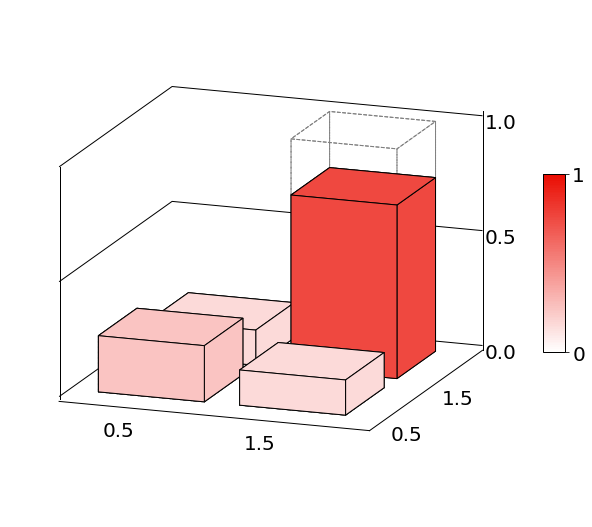

In [90]:
rho = np.mean(rho_n_array_cl_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "", "Identity_client.png", "Reds", client=True)

hi


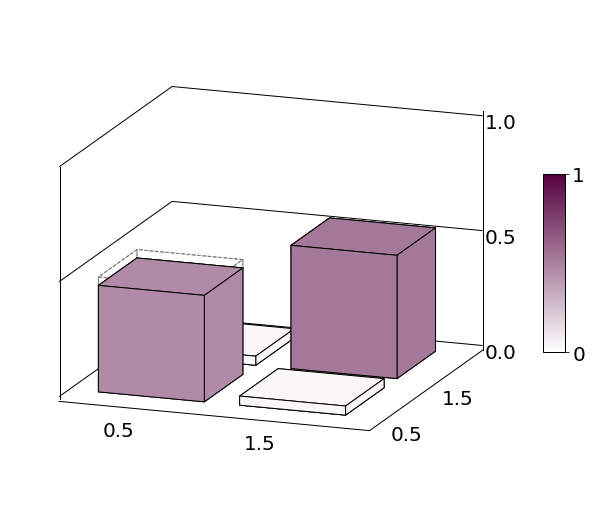

In [92]:
rho = np.mean(rho_n_array_s_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "", "Identity_sever", 'Greens', False)

#### Hadamart

In [111]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
phi_array  = [np.pi/2, np.pi/2, np.pi/2]

cluster_state_length = 3


In [133]:
def plot_from_rho_Had(rho, title, filename, color, client):

    if client == True:
        target = (241/255, 95/255, 88/255)
        start = (1,1,1)
        diff = np.array([1-241/255, 1-95/255, 1-88/255])
        diff = diff/np.max(diff)

    elif client == False:
        target = (116/255, 48/255, 98/255)
        start = (1,1,1)
        diff = np.array([1-116/255, 1-48/255, 1-98/255])
        diff = diff/np.max(diff)

    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1})
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=15)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([2,2])

    for ii in range(2):
        for jj in range(2):
            hist[ii,jj] = np.abs(rho[ii,jj])
            # print(hist[ii,jj])

    dz = hist.ravel()

    cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    max_height = 1  # get range of colorbars so we can normalize
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    if client == True:
        print("TRue")
        hist = np.array([[1, 0],
                        [0, 0]])

    elif client == False:
        print("hi")
        hist = np.array([[0.5, 0],
                        [0, 0.5]])
    

    zpos_hist = np.abs(np.real(rho[:]))
    dz_hist = hist - np.abs(np.real(rho[:]))
    # print('zpos_hist', zpos_hist)
    # print('dz_hist', dz_hist)


    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = zpos_hist.ravel()

    # Construct arrays with the dimensions for the 4 bars.
    dx = dy = 0.75 * np.ones_like(zpos)
    dz = hist.ravel()

    dz = dz_hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1, edgecolor='grey', color=(0, 0, 1, 0))


    ax.plot([0.05,0.05],[0.05,0.05],[-0.01,1], color='k', linewidth=1)
    #ax.plot([0.0,0.0],[2.3,4.3],[0,0.5], color='k', linewidth=1.5)


    ax.set_zticks([0, 0.5, 1])
    ax.set_zlim([0,1])
    # ax.set_zticklabels(["0", "", "1"])

    ax.set_xticks([0.5, 1.5])
    ax.set_xlim([0.09,2.2])
    # ax.set_xticklabels(["$-Y$", "$+Y$"])

    ax.set_yticks([0.5, 1.5])
    ax.set_ylim([0.09,2.2])
    # ax.set_yticklabels(["$-Y$", "$+Y$"])

    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.edge = 0

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
    ax.zaxis._axinfo["grid"]['linewidth'] =  1
    ax.zaxis._axinfo["tick"]['lenght'] =  0

    ax.xaxis.set_tick_params(length=0)
    ax.tick_params(color=(0,0,0,0))

    ax.w_zaxis.linewidth =  1
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    ax.set_title(title)

    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

In [128]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = rho_ideal_Ym

rho_n_array_cl_had = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_had = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_had =  np.empty((0, 3), dtype=float)
nxnynz_s_array_had =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.single_qubit_universal_blind_gate_with_feedback(rho_ideal_Yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_had = np.vstack([rho_n_array_s_had, [rho_s]])
    rho_n_array_cl_had = np.vstack([rho_n_array_cl_had, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_had = np.vstack([nxnynz_cl_array_had, [nxnynz_cl]])
    nxnynz_s_array_had = np.vstack([nxnynz_s_array_had, [nxnynz_s]])
nxnynz_tot_cl_had = np.mean(nxnynz_cl_array_had, axis = 0)
nxnynz_tot_s_had = np.mean(nxnynz_s_array_had, axis = 0)
nxnynz_tot_std_cl_had = np.std(nxnynz_cl_array_had, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_had = np.std(nxnynz_s_array_had, axis = 0)/np.sqrt(n_rounds)

fid_ave_had = np.mean(fid_n, axis = 0)
fid_ave_std_had = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_had)
print(nxnynz_tot_std_cl_had)

print(nxnynz_tot_s_had)
print(nxnynz_tot_std_s_had)

print("Fidelity of a universal Identity gate = ", fid_ave_had, "+-", fid_ave_std_had)


[-0.04140968 -0.03090967  0.12299746]
[0.09072347 0.0848687  0.08154555]
[-0.35760679 -0.37775728  0.16972222]
[0.06344409 0.04977809 0.0787005 ]
Fidelity of a universal Identity gate =  0.6888786482453462 +- 0.024889043570977216


TRue


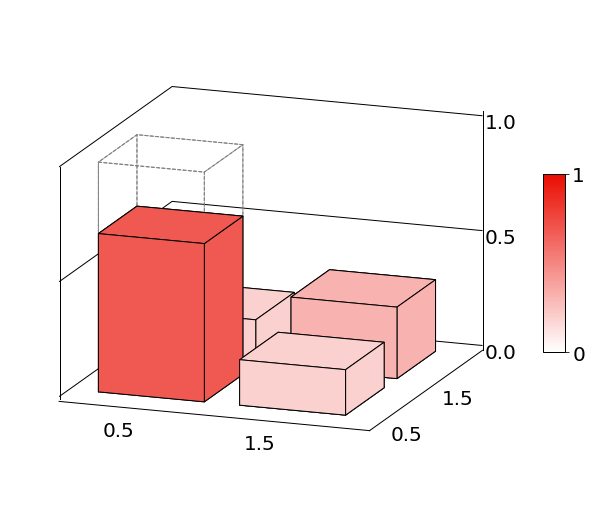

In [134]:
rho = np.mean(rho_n_array_cl_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Had(rho_y, "", "Hadamart_client", 'Reds', True)

hi


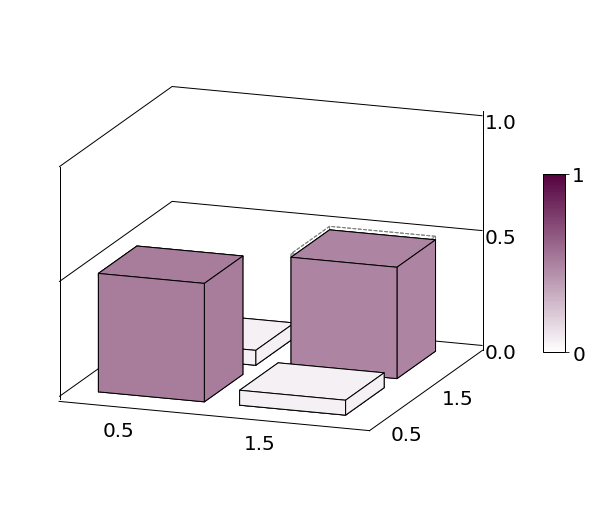

In [135]:
rho = np.mean(rho_n_array_s_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Had(rho_y, "", "Hadamart_sever", 'Greens', False)

#### T sqrt(X) T

In [136]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
phi_array  = [np.pi/4, np.pi/2, np.pi/4]

cluster_state_length = 3

In [137]:
TsqXT = rz(np.pi/4)*rx(np.pi/2)*rz(np.pi/4)
el_rho_final_ideal = TsqXT*rho_ideal_Yp*TsqXT.dag()
print(el_rho_final_ideal)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.85355339+0.j   -0.25      +0.25j]
 [-0.25      -0.25j  0.14644661+0.j  ]]


In [138]:
def plot_from_rho_TXT(rho, title, filename, color, client):

    if client == True:
        target = (241/255, 95/255, 88/255)
        start = (1,1,1)
        diff = np.array([1-241/255, 1-95/255, 1-88/255])
        diff = diff/np.max(diff)

    elif client == False:
        target = (116/255, 48/255, 98/255)
        start = (1,1,1)
        diff = np.array([1-116/255, 1-48/255, 1-98/255])
        diff = diff/np.max(diff)

    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1})
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=15)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([2,2])

    for ii in range(2):
        for jj in range(2):
            hist[ii,jj] = np.abs(rho[ii,jj])
            # print(hist[ii,jj])

    dz = hist.ravel()

    cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    max_height = 1  # get range of colorbars so we can normalize
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 1, 2])
    yedges = np.array([0, 1, 2])

    if client == True:
        print("TRue")
        hist = np.array([[0, 0],
                        [0, 1]])

    elif client == False:
        print("hi")
        hist = np.array([[0.5, 0],
                        [0, 0.5]])
    

    zpos_hist = np.abs(np.real(rho[:]))
    dz_hist = hist - np.abs(np.real(rho[:]))
    # print('zpos_hist', zpos_hist)
    # print('dz_hist', dz_hist)


    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = zpos_hist.ravel()

    # Construct arrays with the dimensions for the 4 bars.
    dx = dy = 0.75 * np.ones_like(zpos)
    dz = hist.ravel()

    dz = dz_hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1, edgecolor='grey', color=(0, 0, 1, 0))


    ax.plot([0.05,0.05],[0.05,0.05],[-0.01,1], color='k', linewidth=1)
    #ax.plot([0.0,0.0],[2.3,4.3],[0,0.5], color='k', linewidth=1.5)


    ax.set_zticks([0, 0.5, 1])
    ax.set_zlim([0,1])
    # ax.set_zticklabels(["0", "", "1"])

    ax.set_xticks([0.5, 1.5])
    ax.set_xlim([0.09,2.2])
    # ax.set_xticklabels(["$-Y$", "$+Y$"])

    ax.set_yticks([0.5, 1.5])
    ax.set_ylim([0.09,2.2])
    # ax.set_yticklabels(["$-Y$", "$+Y$"])

    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.edge = 0

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
    ax.zaxis._axinfo["grid"]['linewidth'] =  1
    ax.zaxis._axinfo["tick"]['lenght'] =  0

    ax.xaxis.set_tick_params(length=0)
    ax.tick_params(color=(0,0,0,0))

    ax.w_zaxis.linewidth =  1
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    ax.set_title(title)

    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

In [120]:
n_rounds = 30 # estimate for 6 hrs of run

rho_n_array_cl_txt = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_txt = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_txt =  np.empty((0, 3), dtype=float)
nxnynz_s_array_txt =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.single_qubit_universal_blind_gate_with_feedback(rho_ideal_Yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_txt = np.vstack([rho_n_array_s_txt, [rho_s]])
    rho_n_array_cl_txt = np.vstack([rho_n_array_cl_txt, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_txt = np.vstack([nxnynz_cl_array_txt, [nxnynz_cl]])
    nxnynz_s_array_txt = np.vstack([nxnynz_s_array_txt, [nxnynz_s]])
nxnynz_tot_cl_txt = np.mean(nxnynz_cl_array_txt, axis = 0)
nxnynz_tot_s_txt = np.mean(nxnynz_s_array_txt, axis = 0)
nxnynz_tot_std_cl_txt = np.std(nxnynz_cl_array_txt, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_txt = np.std(nxnynz_s_array_txt, axis = 0)/np.sqrt(n_rounds)

fid_ave_txt = np.mean(fid_n, axis = 0)
fid_ave_std_txt = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_txt)
print(nxnynz_tot_std_cl_txt)

print(nxnynz_tot_s_txt)
print(nxnynz_tot_std_s_txt)

print("Fidelity of a universal Identity gate = ", fid_ave_txt, "+-", fid_ave_std_txt)


[0.03664483 0.08867062 0.11449686]
[0.07605466 0.09139116 0.08754773]
[-0.3385107  -0.42473261  0.21805802]
[0.04482659 0.05100164 0.08072554]
Fidelity of a universal Identity gate =  0.7679059833060153 +- 0.029503562629352855


TRue


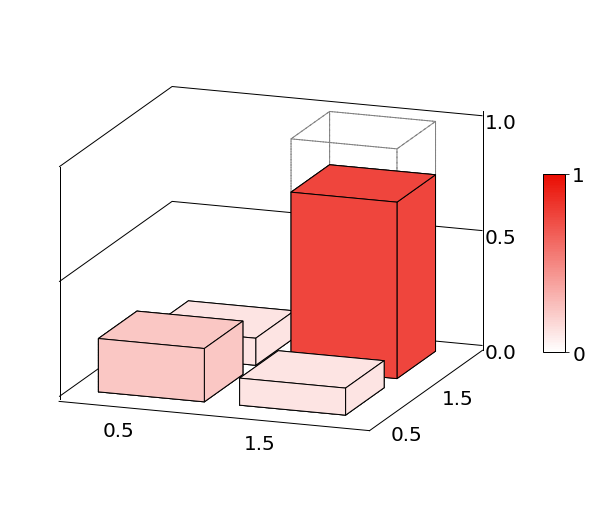

In [142]:
rho = np.mean(rho_n_array_cl_txt, axis = 0)
# to TXTy basis 
U_txt = U_transform_ztoy*TsqXT.dag()
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_Identity(rho_y, "", "TXT_client", 'Blues', True)

hi


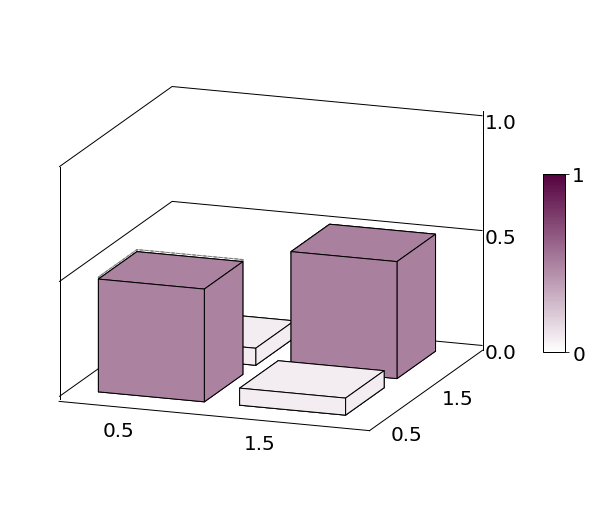

In [141]:
rho = np.mean(rho_n_array_s_txt, axis = 0)
# from Z to Y basis
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_TXT(rho_y, "", "TXT_server", 'Blues', False)

#### Blindness for the universal single qubit gate

In [145]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.concatenate(([nxnynz_tot_s_id], [nxnynz_tot_s_had], [nxnynz_tot_s_txt]), axis=0)
std_nxnynz = np.concatenate(([nxnynz_tot_std_s_id], [nxnynz_tot_std_s_had], [nxnynz_tot_std_s_txt]), axis=0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_id, axis = 0),np.mean(rho_n_array_s_had, axis = 0), np.mean(rho_n_array_s_txt, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
print(rho_lambdas)
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]
hv_std = holevo_bound_uncertainty_1q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


[(0.20209263949535178, 0.7979073605046483), (0.22641783160500617, 0.7735821683949938), (0.20736687434703616, 0.7926331256529638)]
Holevo bound is =  0.0023210395831750885 0.01087560074155486


## B16 Intranode two-qubit gate 

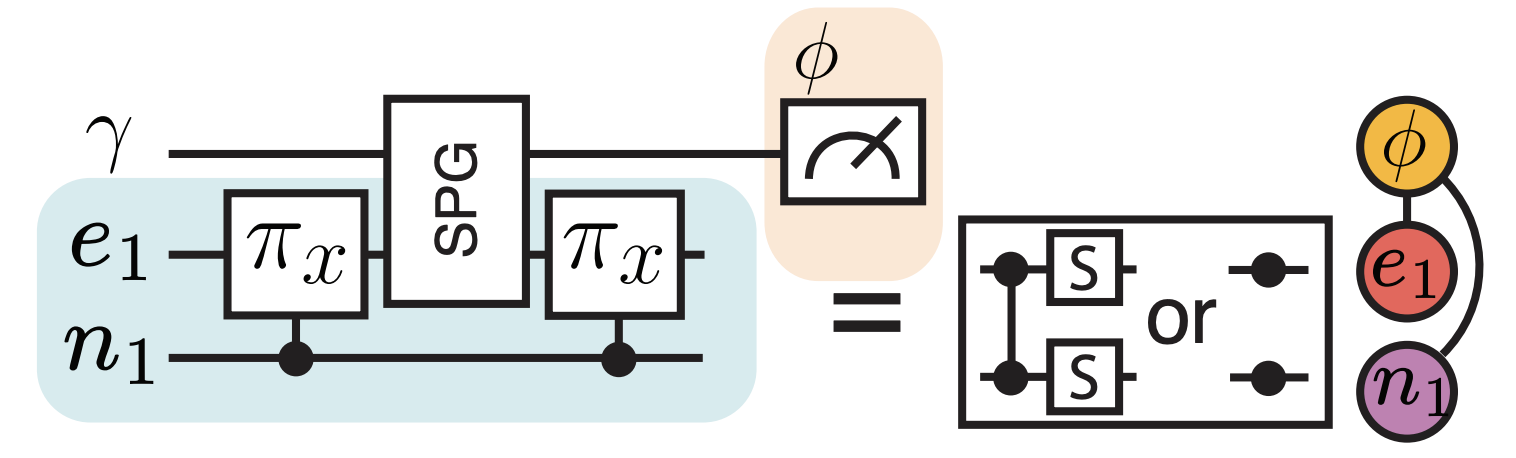

In [8]:
Image(filename='/Users/azizasuleymanzade/Lukin SiV Dropbox/Aziza azizasuleymanzade@g.harvard.edu/bqc_paper/Simulation/Notebooks/FiguresJupyter/Intranode_2qubit.png')

In [240]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.2
eln_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

In [241]:
SS = qt.tensor(s_gate(), s_gate())
CZ_gate = cphase(np.pi, N=2, control=0, target=1)
Ent_gate = SS*CZ_gate
el_rho_final_ideal_0 = eln_initial # identity operation
el_rho_final_ideal_pi2 =Ent_gate*eln_initial*Ent_gate.dag() # S1S2CZ
el_rho_final_ideal_pi4 =qt.ket2dm(qt.tensor((qt.basis(2,0) + np.exp(-1j*((np.pi/4)))*qt.basis(2,1)).unit(), qt.basis(2,1)) \
          + np.exp(-1j*(np.pi/4))*qt.tensor((qt.basis(2,0) + np.exp(1j*(np.pi/4))*qt.basis(2,1)).unit(), qt.basis(2,0))).unit()
el_rho_final_ideal_3pi4 =qt.ket2dm(qt.tensor((qt.basis(2,0) + np.exp(-1j*((3*np.pi/4)))*qt.basis(2,1)).unit(), qt.basis(2,1)) \
          + np.exp(-1j*(3*np.pi/4))*qt.tensor((qt.basis(2,0) + np.exp(1j*(3*np.pi/4))*qt.basis(2,1)).unit(), qt.basis(2,0))).unit()

##### Angle = 0

In [143]:
n_rounds = 40
rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
fid_n_0 =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, 0, mu)
    rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_output[0]]])
    rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_0))**2
    fid_n_0 = np.append(fid_n_0, fid)
    
fid_ave_0 = np.mean(fid_n_0, axis = 0)
fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_0, "+-", fid_ave_std_0)

Fidelity of an intranode gate =  0.9999292688560146 +- 6.384324623685209e-10


##### Angle = pi4

In [144]:
n_rounds = 40
rho_n_array_cl_pi4 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_pi4 = np.empty((0, 4, 4), dtype=complex)
fid_n_pi4=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, np.pi/4, mu)
    rho_n_array_s_pi4 = np.vstack([rho_n_array_s_pi4, [rho_output[0]]])
    rho_n_array_cl_pi4 = np.vstack([rho_n_array_cl_pi4, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_pi4))**2
    fid_n_pi4 = np.append(fid_n_pi4, fid)
    
fid_ave_pi4 = np.mean(fid_n_pi4, axis = 0)
fid_ave_std_pi4 = np.std(fid_n_pi4, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_pi4, "+-", fid_ave_std_pi4)

Fidelity of an intranode gate =  0.9999292663099855 +- 1.4714424401587258e-09


##### Angle = pi/2

In [145]:
n_rounds = 40
rho_n_array_cl_pi2 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_pi2 = np.empty((0, 4, 4), dtype=complex)
fid_n_pi2=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, np.pi/2, mu)
    rho_n_array_s_pi2 = np.vstack([rho_n_array_s_pi2, [rho_output[0]]])
    rho_n_array_cl_pi2 = np.vstack([rho_n_array_cl_pi2, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_pi2))**2
    fid_n_pi2 = np.append(fid_n_pi2, fid)
    
fid_ave_pi2 = np.mean(fid_n_pi2, axis = 0)
fid_ave_std_pi2 = np.std(fid_n_pi2, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_pi2, "+-", fid_ave_std_pi2)

Fidelity of an intranode gate =  0.9999292844717956 +- 5.184461280115058e-10


##### Angle = 3pi/4

In [146]:
rho_n_array_cl_3pi4 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_3pi4 = np.empty((0, 4, 4), dtype=complex)
fid_n_3pi4=  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = sim.two_qubit_intranode_blind_gate(eln_initial, imperfections, 3*np.pi/4, mu)
    rho_n_array_s_3pi4 = np.vstack([rho_n_array_s_3pi4, [rho_output[0]]])
    rho_n_array_cl_3pi4 = np.vstack([rho_n_array_cl_3pi4, [rho_output[1]]])
   
    fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_3pi4))**2
    fid_n_3pi4 = np.append(fid_n_3pi4, fid)
    
fid_ave_3pi4 = np.mean(fid_n_3pi4, axis = 0)
fid_ave_std_3pi4 = np.std(fid_n_3pi4, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_3pi4, "+-", fid_ave_std_3pi4)

Fidelity of an intranode gate =  0.9999292826812468 +- 2.616005979284679e-09


#### Blindness of Intranode gate

#### Blindness over, 0, pi/4, pi/2, 3pi/4

In [147]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0),np.mean(rho_n_array_s_pi4, axis = 0), np.mean(rho_n_array_s_pi2, axis = 0), np.mean(rho_n_array_s_3pi4, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
eigen_phis_pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi4]
eigen_phis_pi2 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi2]
eigen_phis_3pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_3pi4]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0),np.mean(eigen_phis_pi4, axis = 0),np.mean(eigen_phis_pi2, axis = 0),np.mean(eigen_phis_3pi4, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor,np.std(eigen_phis_pi4, axis = 0)/factor,np.std(eigen_phis_pi2, axis = 0)/factor,np.std(eigen_phis_3pi4, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor
hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (eigen_tot_std, eigen_tot_std, eigen_tot_std, eigen_tot_std)
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas =  eigen_phis_std
hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)

Holevo bound is =  0.006281979249668002 2.0592648196991883


In [139]:
eigen_phis

array([[1.19277112e-16, 9.02210955e-17, 1.54326128e-02, 9.84567387e-01],
       [1.21631666e-16, 9.59296800e-17, 1.48690915e-02, 9.85130908e-01],
       [1.11138395e-16, 4.72775254e-14, 1.58340088e-02, 9.84165991e-01],
       [1.15266459e-16, 1.89968376e-13, 1.63581997e-02, 9.83641800e-01]])

#### BLindness over the 0 and pi/2

In [135]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0),np.mean(rho_n_array_s_pi4, axis = 0), np.mean(rho_n_array_s_pi2, axis = 0), np.mean(rho_n_array_s_3pi4, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
# eigen_phis_pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi4]
eigen_phis_pi2 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_pi2]
# eigen_phis_3pi4 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_3pi4]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0),np.mean(eigen_phis_pi2, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor,np.std(eigen_phis_pi2, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor
hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (eigen_tot_std, eigen_tot_std, eigen_tot_std, eigen_tot_std)
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas =  eigen_phis_std
hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)

Holevo bound is =  0.010002458968111139 1.3523303796729809


In [136]:
eigen_phis

array([[1.19277112e-16, 9.02210955e-17, 1.54326128e-02, 9.84567387e-01],
       [1.11138395e-16, 4.72775254e-14, 1.58340088e-02, 9.84165991e-01]])

In [128]:
rho_tot_lambdas

array([6.03680280e-15, 7.45464874e-03, 2.94390800e-01, 6.98154552e-01])

In [129]:
rho_tot_sigma_lambdas

(0.04500981092308738,
 0.04500981092308738,
 0.04500981092308738,
 0.04500981092308738)

In [130]:
rho_lambdas

array([[1.19277112e-16, 9.02210955e-17, 1.54326128e-02, 9.84567387e-01],
       [1.11138395e-16, 4.72775254e-14, 1.58340088e-02, 9.84165991e-01]])

In [131]:
rho_sigma_lambdas

array([[1.47154918e-17, 1.13196141e-17, 1.21172004e-03, 1.21172004e-03],
       [1.22617247e-17, 4.65913955e-14, 4.29185958e-04, 4.29185958e-04]])

#### Full Gate set tomography

In [156]:
input_states = [
    qt.ket2dm(qt.tensor(qt.basis(2, 0), qt.basis(2, 0))),  # |00⟩
    qt.ket2dm(qt.tensor(qt.basis(2, 0), qt.basis(2, 1))),  # |01⟩
    qt.ket2dm(qt.tensor(qt.basis(2, 1), qt.basis(2, 0))),  # |10⟩
    qt.ket2dm(qt.tensor(qt.basis(2, 1), qt.basis(2, 1))),  # |11⟩
    qt.ket2dm((qt.tensor(qt.basis(2, 0), qt.basis(2, 0)) + qt.tensor(qt.basis(2, 0), qt.basis(2, 1))).unit()),  # |00⟩ + |01⟩
    qt.ket2dm((qt.tensor(qt.basis(2, 1), qt.basis(2, 0)) + qt.tensor(qt.basis(2, 1), qt.basis(2, 1))).unit())   # |10⟩ + |11⟩
]

##### For phi = 0

In [242]:
n_rounds = 40

## the arrays across the input states
rho_array_cl_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
rho_array_s_0_states = np.empty((0, n_rounds, 4, 4), dtype=complex)
fid_0_states =  np.empty((0, 2), dtype=float)

for i_s in input_states:
    ## the arrays within the rounds
    rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
    rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
    fid_n_0 =  np.empty((0, 2), dtype=float)
    rho_n_0 =  np.empty((0, 4, 4), dtype=complex)
    for i in range(n_rounds):
        # if i%100==0:
        #     print(i)
        rho_output = sim.two_qubit_intranode_blind_gate(i_s, imperfections, np.pi/2, mu)
        rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_output[0]]])
        rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_output[1]]])
    
        fid = (qt.fidelity(qt.Qobj(rho_output[1]), el_rho_final_ideal_0))**2
        fid_n_0 = np.append(fid_n_0, fid)
    
    fid_ave_0 = np.mean(fid_n_0, axis = 0)
    fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))
    rho_array_s_0_states = np.vstack([rho_array_s_0_states, [rho_n_array_s_0]])
    rho_array_cl_0_states = np.vstack([rho_array_cl_0_states, [rho_n_array_cl_0]])

rho_output_ave_states = np.mean(rho_array_cl_0_states, axis = 1)

In [252]:
from scipy.linalg import lstsq  # Import lstsq to solve the linear system

## create the chi matrix
A = []
b = []
pauli_operators = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
pauli_basis = [qt.tensor(p1, p2) for p1 in pauli_operators for p2 in pauli_operators]  # 16 operators for 2-qubit


# For each input-output pair
for i, rho_in in enumerate(input_states):
    rho_out = rho_output_ave_states[i]  # Use the corresponding output density matrix
    # Vectorize the output density matrix
    b.append(qt.operator_to_vector(qt.Qobj(rho_out)).full().flatten())

    # Create the matrix terms for each basis operation
    row = []
    for Pm in pauli_basis:
        for Pn in pauli_basis:
            term = Pm * rho_in * Pn.dag()
            row.append(qt.operator_to_vector(term).full().flatten())

    # Stack rows to form matrix A
    A.append(np.array(row).T)

# Concatenate A and b into the correct shape for least-squares solving
A = np.vstack(A)
b = np.hstack(b)

# Solve for the chi matrix elements
chi_vector, _, _, _ = lstsq(A, b)  # Least-squares solution
chi_matrix = np.round(chi_vector.reshape((16, 16)), 3)  # Reshape into 16x16 matrix for two qubits
for i in range(chi_matrix.shape[0]):
    for j in range(chi_matrix.shape[1]):
        x = chi_matrix[i, j]
        if x == 0:
            formatted_matrix[i, j] = "0"  # Exact zero
        elif x.imag == 0:
            formatted_matrix[i, j] = f"{x.real:.2f}"  # Real-only value
        elif x.real == 0:
            formatted_matrix[i, j] = f"{x.imag:.2f}j"  # Imaginary-only value
        else:
            formatted_matrix[i, j] = f"{x.real:.2f}+{x.imag:.2f}j"
formatted_matrix

array([['0.19', '0', '0.00+0.00j', '0.01+0.00j', '-0.00+0.00j',
        '0.00+-0.00j', '0', '-0.00+0.00j', '0.00+-0.00j', '-0.00',
        '0.00+-0.00j', '-0.00+0.00j', '0.01', '-0.00', '0.00+-0.00j',
        '-0.01+0.09j'],
       ['0', '-0.04', '0', '-0.00', '0.00+-0.00j', '0.00+0.00j', '-0.00',
        '-0.00+0.00j', '-0.00', '0.00+-0.00j', '0.00+0.00j', '0',
        '-0.00', '0.01', '0.09', '0'],
       ['-0.00+-0.00j', '0', '0.04', '0', '-0.00', '-0.00',
        '-0.00+-0.00j', '0.00+0.00j', '-0.00+0.00j', '0.00+0.00j',
        '-0.00+0.00j', '-0.00+-0.00j', '-0.00+0.00j', '0.09', '-0.01',
        '-0.00+-0.00j'],
       ['0.01+-0.00j', '-0.00', '0', '0.28', '-0.00+0.00j',
        '-0.00+0.00j', '-0.00+-0.00j', '-0.01+-0.00j', '-0.00+-0.00j',
        '0', '0.00+0.00j', '0', '-0.01+-0.09j', '0', '0.00+0.00j',
        '-0.00'],
       ['-0.00+-0.00j', '0.00+0.00j', '-0.00', '-0.00+-0.00j', '0.01',
        '0', '-0.00+-0.00j', '-0.01', '0.00+-0.00j', '0.00+0.00j',
        '-0.00', '0

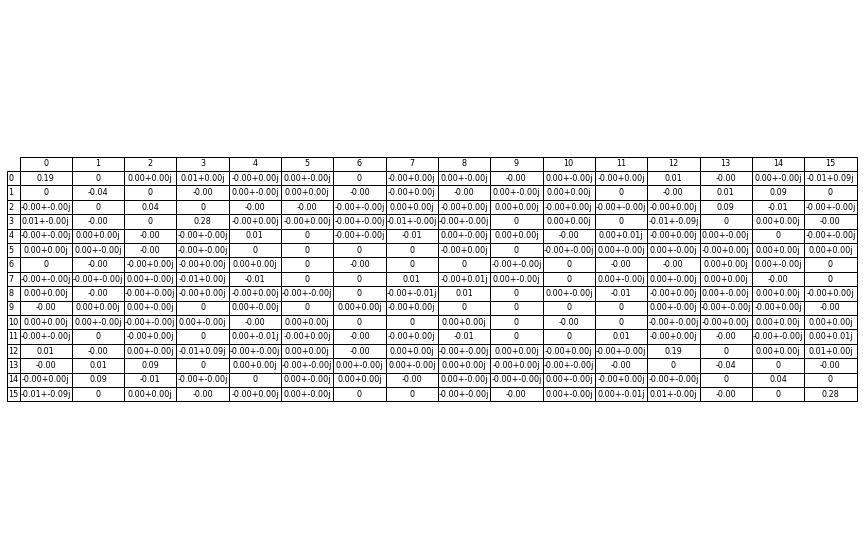

In [254]:
# Create a DataFrame for better labeling
df = pd.DataFrame(formatted_matrix)

# Set up the figure and axis for Matplotlib
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size as needed

# Hide the default axis
ax.axis('off')

# Create a table plot with borders
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 cellLoc='center',
                 loc='center')

# Apply styling to add borders and enhance appearance
table.scale(1, 1.2)  # Adjust scaling if needed
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 1)  # Increase cell size by a factor of 2


# Set borders for each cell
for i in range(len(df.index)):
    for j in range(len(df.columns)):
        cell = table[i, j]
        cell.set_edgecolor('black')
        cell.set_linewidth(1)

# Save the figure as a file
plt.savefig("16x16_table_pi2.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.savefig("16x16_table_pi2.pdf", dpi=300, bbox_inches='tight')  # Save as PDF
plt.show()

In [ ]:
def plot_from_rho(rho, title, filename, color, ON):

    # not sensitive to imaginary elements of the density matrix
    plt.rcParams.update({'font.size': 20, 'axes.linewidth': 1.5})


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(azim=-70, elev=25)
    ax.set_proj_type('ortho')

    xedges = np.array([0, 1, 2, 3, 4])
    yedges = np.array([0, 1, 2, 3, 4])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.75 * np.ones_like(zpos)

    hist = np.zeros([4,4])

    for ii in range(4):
        for jj in range(4):
            hist[ii,jj] = np.abs(np.abs(rho[ii,jj]))

    dz = hist.ravel()

    #cmap = plt.cm.get_cmap(color) # Get desired colormap - you can change this!
    
    target = color
    start = (1,1,1)
    diff = np.array([1-target[0], 1-target[1], 1-target[2]])
    diff = diff/np.max(diff)

    N = 100
    color_list = []
    bounds = np.linspace(0,1,N)

    for ii in range(N):
        color_list.append((start[0] - diff[0]*ii/N, start[1] - diff[1]*ii/N, start[2] - diff[2]*ii/N))

    cmap = mpl.colors.ListedColormap(color_list)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    if ON:
        max_height = 0.5  # get range of colorbars so we can normalize
    else:
        max_height = 1.0
    min_height = 0
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 

    xpos_ori, ypos_ori, zpos_ori, dx_ori, dy_ori, dz_ori \
        = xpos, ypos, zpos, dx.copy(), dy.copy(), dz.copy()
#     ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', linestyle='-', linewidth=1.5, edgecolor='k', color=rgba, shade=False)


    xedges = np.array([0, 3, 6])
    yedges = np.array([0, 3, 6])

    if ON:
        hist = 0.5*np.ones([2,2])


        zpos_hist = np.abs(np.real(rho[0:4:3,0:4:3]))
        dz_hist = hist - np.abs(np.real(rho[0:4:3,0:4:3]))

        # Construct arrays for the anchor positions of the 16 bars.
        xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = zpos_hist.ravel()

        # Construct arrays with the dimensions for the 16 bars.
        dx = dy = 0.75 * np.ones_like(zpos)
        dz = hist.ravel()

        hist = 0.5*np.ones([2,2])

        dz = dz_hist.ravel()

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1.5, edgecolor='grey', color=(0, 0, 1, 0))


        ax.plot([0,0],[0,0],[-0.01,0.5], color='k', linewidth=1.5)
        ax.plot([0.0,0.0],[4.3,4.3],[0,0.5], color='k', linewidth=1.5)


        ax.set_zticks([0, 0.25, 0.5])
        ax.set_zlim([0,0.5])
        ax.set_zticklabels(["0", "", "0.5"])

        ax.set_xticks([0.5, 1.5, 2.5, 3.5])
        ax.set_xlim([0.09,4.2])
        ax.set_xticklabels(["$+i+i$", "$+i-i$", "$-i +i$", "$-i-i$"])

        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.set_ylim([0.09,4.2])
        ax.set_yticklabels(["$+i+i$", "$+i-i$", "$-i +i$", "$-i-i$"])

        ax.w_xaxis.set_pane_color((0, 0, 0, 0))
        ax.w_yaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.edge = 0

        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
        ax.zaxis._axinfo["grid"]['linewidth'] =  1.5
        ax.zaxis._axinfo["tick"]['lenght'] =  0

        ax.xaxis.set_tick_params(length=0)
        ax.tick_params(color=(0,0,0,0))

        ax.w_zaxis.linewidth =  1.5
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(["0", "1.0"])

    else:
        hist = np.array([[0,0,0,0],
                         [0,0,0,0],
                         [0,0,0,0],
                         [0,0,0,1]])
        
        zpos_hist = np.abs(np.real(rho))
        dz_hist = hist - np.abs(np.real(rho))

        # Construct arrays for the anchor positions of the 16 bars.
#         xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
        xpos, ypos = np.meshgrid(np.array([0, 1, 2, 3]) + 0.25, np.array([0, 1, 2, 3]) + 0.25, indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = zpos_hist.ravel()

        # Construct arrays with the dimensions for the 16 bars.
        dx = dy = 0.75 * np.ones_like(zpos)
        dz = hist.ravel()

        hist = 0.5*np.ones([4,4])

        dz = dz_hist.ravel()

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='min', linestyle='--', linewidth=1.5, edgecolor='grey', color=(0, 0, 1, 0))


        ax.plot([0,0],[0,0],[-0.01,1.0], color='k', linewidth=1.5)
        ax.plot([0.0,0.0],[4.3,4.3],[0,1.0], color='k', linewidth=1.5)


        ax.set_zticks([0, 0.5, 1.0])
        ax.set_zlim([0,1.0])
        ax.set_zticklabels(["0", "", "1"])

        ax.set_xticks([0.5, 1.5, 2.5, 3.5])
        ax.set_xlim([0.09,4.2])
        ax.set_xticklabels(["$- -$", "$- +$", "$+ -$", "$+ +$"])

        ax.set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.set_ylim([0.09,4.2])
        ax.set_yticklabels(["$- -$", "$- +$", "$+ -$", "$+ +$"])

        ax.w_xaxis.set_pane_color((0, 0, 0, 0))
        ax.w_yaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.set_pane_color((0, 0, 0, 0))
        ax.w_zaxis.edge = 0

        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (0,0,0,1)
        ax.zaxis._axinfo["grid"]['linewidth'] =  1.5
        ax.zaxis._axinfo["tick"]['lenght'] =  0

        ax.xaxis.set_tick_params(length=0)
        ax.tick_params(color=(0,0,0,0))

        ax.w_zaxis.linewidth =  1.5
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.04, pad=0.04, aspect=8)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(["0", "1.0"])
        
    ax.bar3d(xpos_ori, ypos_ori, zpos_ori, dx_ori, dy_ori, dz_ori, \
             zsort='average', linestyle='-', linewidth=1.5, edgecolor='k', color=rgba, shade=False)
    ax.set_title(title)


    plt.show()
    fig.savefig(filename, bbox_inches='tight', dpi=300)

## Setup Two-Node experiments in B16-G12

In [41]:
# Create Networks:
g12_b16_network = FiberNetwork(siv_a, siv_b) # this device is now in B16 fridge

# Create Simulation:
sim2 = BlindComputing(g12_b16_network)

In [42]:
# Setup efficiencies

g12_b16_network.fibercoupling_eff = 0.6
g12_b16_network.tdi_eff = 0.35*0.3
g12_b16_network.snspd_eff = 0.9
g12_b16_network.detection_eff
g12_b16_network.detection_eff_reset()
g12_b16_network.link_efficiency = (g12_b16_network.fibercoupling_eff**2)*0.05*0.64

print('Detection efficientvy is = ', g12_b16_network.detection_eff)
print('Link efficientvy is = ', g12_b16_network.link_efficiency)

Detection efficientvy is =  0.0567
Link efficientvy is =  0.011519999999999999


#### MW gates

In [43]:
# gate fidelities
b16_mwfid = 0.99
g12_mwfid = 0.98

#### Move the SiV to the desired contrast point

In [44]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

siv_a.set_contrast(g12_contrast)
actual_contrast_g12 = siv_a.get_best_contrast()
print("G12 contrast is set to = ", actual_contrast_g12)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378
new contrast 22.984605715760697
G12 contrast is set to =  22.984605715760697


## B16-G12 Internode two-qubit gate

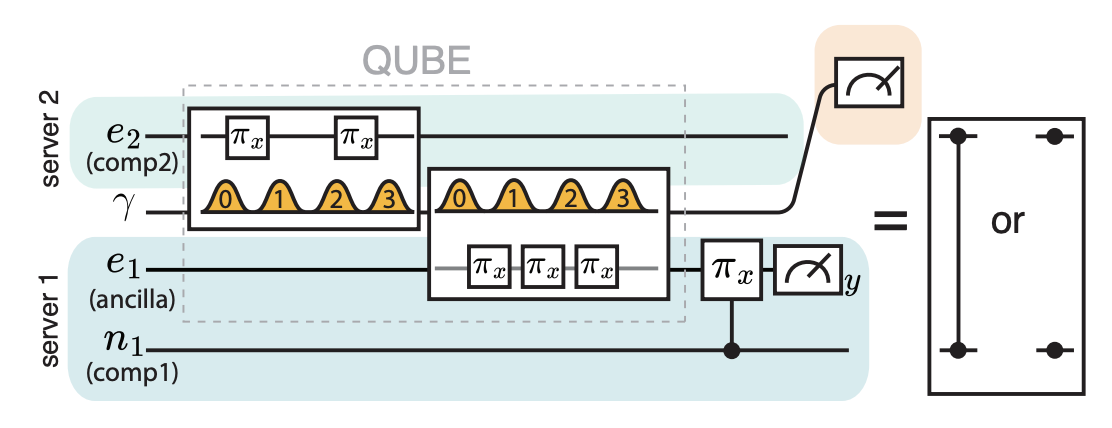

In [10]:
Image(filename='/Users/azizasuleymanzade/Dropbox (Personal)/Aziza/LukinLab/BlindComputing/SimulationCode_Aziza/Notebooks/FiguresJupyter/QUBE_gate.png')

In [98]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.0003
Entange = 0 # choices are {0, 1}
# e1e2n2
een_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp, rho_ideal_Xp)
Had = (1/np.sqrt(2))*qt.Qobj([[1, 1],[1, -1]])

### Try once perfect gates: entanglement on and off

In [99]:
Entange = 1
rho_final = sim2.two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
# transform for plotting
if Entange == 0:
    oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))

elif Entange == 1:
    oper_transform = qt.tensor(rx(np.pi/2), rx(np.pi/2))

rho = oper_transform*rho_final[1]*oper_transform.dag()
print(rho_final[0])
print(rho_final[1])
print(rho)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25+0.j         -0.25+0.j          0.  +0.24970363j  0.  +0.24970363j]
 [-0.25+0.j          0.25+0.j          0.  -0.24970363j  0.  -0.24970363j]
 [ 0.  -0.24970363j  0.  +0.24970363j  0.25+0.j          0.25+0.j        ]
 [ 0.  -0.24970363j  0.  +0.24970363j  0.25+0.j          0.25+0.j        ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25        0.25        0.24970363 -0.24970363]
 [ 0.25        0.25        0.24970363 -0.24970363]
 [ 0.24970363  0.24970363  0.25       -0.25      ]
 [-0.24970363 -0.24970363 -0.25        0.25      ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[4.99703630e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+4.99703630e-01j]
 [0.00000000e+00+0.00000000e+00j 2.96370259e-04+0.00000000e+00j
  0.00000000e

In [47]:
plot_from_rho(rho, 'client', 'entangling_phi=0.svg', (246/255, 133/255, 32/255), True)

NameError: name 'plot_from_rho' is not defined

In [ ]:
plot_from_rho(rho, 'client', 'entangling_phi=0.svg', (246/255, 133/255, 32/255), False)

NameError: name 'plot_from_rho' is not defined

### Run many averages: entanglement on and off

In [100]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.07
# e1e2n2
een_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp, rho_ideal_Xp)
Had = (1/np.sqrt(2))*qt.Qobj([[1, 1],[1, -1]])

##### Non-entangling gate

In [101]:
Entange = 0 # choices are {0, 1}
n_rounds = 4
rho_n_array_cl_0 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0 = np.empty((0, 4, 4), dtype=complex)
fid_n_0 =  np.empty((0, 2), dtype=float)
el_rho_final_ideal_0 = qt.tensor(rho_ideal_Xp, rho_ideal_Xp)

for i in range(n_rounds):
    print(i)
    rho_output = sim2.two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
    rho_cl = rho_output[1]
    rho_s = rho_output[0]
    rho_n_array_s_0 = np.vstack([rho_n_array_s_0, [rho_s]])
    rho_n_array_cl_0 = np.vstack([rho_n_array_cl_0, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal_0))**2
    fid_n_0 = np.append(fid_n_0, fid)
    
fid_ave_0 = np.mean(fid_n_0, axis = 0)
fid_ave_std_0 = np.std(fid_n_0, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_0, "+-", fid_ave_std_0)

0
1
2
3
Fidelity of an intranode gate =  0.7088511357240649 +- 0.05866648185649332


##### Entangling gate

In [102]:
Entange = 1 # choices are {0, 1}
n_rounds = 4
rho_n_array_cl_1 = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_1 = np.empty((0, 4, 4), dtype=complex)
oper_transform = qt.tensor(rx(np.pi/2), rx(np.pi/2))
fid_n_1 =  np.empty((0, 2), dtype=float)
el_rho_final_ideal_1 = qt.ket2dm((qt.tensor(psi_ideal_Yp, psi_ideal_Xm) + qt.tensor(psi_ideal_Ym, psi_ideal_Xp)).unit())
for i in range(n_rounds):
    # if i%100==0:
    print(i)
    rho_output = sim2.two_qubit_internode_blind_gate(een_initial, imperfections, Entange, mu)
    rho_cl = rho = oper_transform*rho_output[1]*oper_transform.dag()
    rho_s = rho = oper_transform*rho_output[0]*oper_transform.dag()
    rho_n_array_s_1 = np.vstack([rho_n_array_s_1, [rho_s]])
    rho_n_array_cl_1 = np.vstack([rho_n_array_cl_1, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal_1))**2
    fid_n_1 = np.append(fid_n_1, fid)
    
fid_ave_1 = np.mean(fid_n_1, axis = 0)
fid_ave_std_1 = np.std(fid_n_1, axis = 0)/(np.sqrt(n_rounds))

print("Fidelity of an intranode gate = ", fid_ave_1, "+-", fid_ave_std_1)

0
1
2
3
Fidelity of an intranode gate =  0.7925554934226405 +- 0.013989871256931203


In [103]:
rho_ave_1 = np.mean(rho_n_array_cl_1, axis = 0)
plot_from_rho(rho_ave_1, 'client', 'entangling_phi=0.svg', (246/255, 133/255, 32/255), True)

NameError: name 'plot_from_rho' is not defined

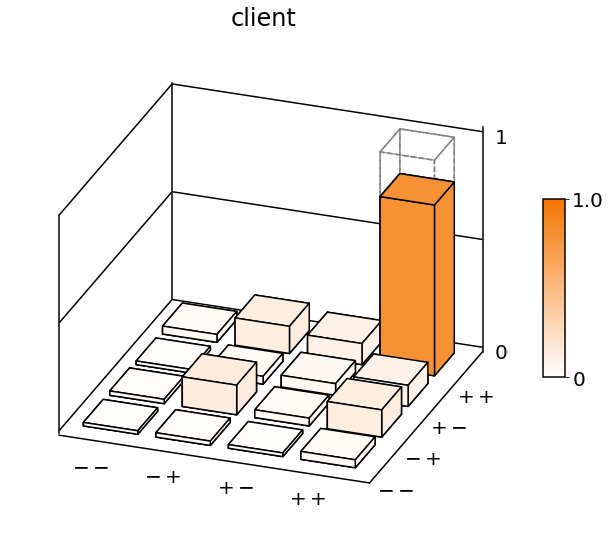

In [ ]:
rho_ave_0 = np.mean(rho_n_array_cl_0, axis = 0)
oper_transform = qt.tensor(ry(np.pi/2), ry(np.pi/2))
rho = oper_transform*rho_ave_0*oper_transform.dag()
plot_from_rho(rho, 'client', 'entangling_phi=0.svg', (246/255, 133/255, 32/255), False)

#### Blindness of Internode gate

In [104]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_0, axis = 0), np.mean(rho_n_array_s_1, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_0 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_0]
eigen_phis_1 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_1]

factor = np.sqrt(len(eigen_phis_0))
eigen_phis = np.array([np.mean(eigen_phis_0, axis = 0), np.mean(eigen_phis_1, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_0, axis = 0)/factor,np.std(eigen_phis_1, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (eigen_tot_std, eigen_tot_std, eigen_tot_std, eigen_tot_std)
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)

Holevo bound is =  0.2498261863765453 0.11663658765630541


In [105]:
rho_tot_lambdas

array([0.0922183 , 0.14676298, 0.31887263, 0.4421461 ])

In [106]:
rho_tot_sigma_lambdas

(0.0694696470947693,
 0.0694696470947693,
 0.0694696470947693,
 0.0694696470947693)

In [107]:
rho_lambdas

array([[2.95443084e-04, 6.03732083e-04, 1.43170759e-01, 8.55930065e-01],
       [4.37524285e-03, 1.02462420e-02, 1.23599276e-01, 8.61779240e-01]])

In [108]:
rho_sigma_lambdas

array([[0.0001641 , 0.00038647, 0.0149972 , 0.01538991],
       [0.00025225, 0.000829  , 0.00544209, 0.0065037 ]])

## Deutsch-Jozsa algorithm

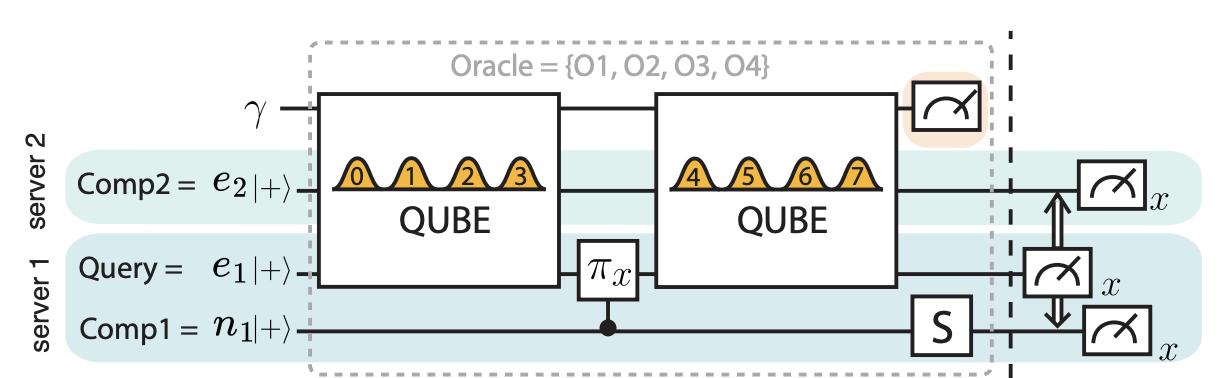

In [13]:
Image(filename='/Users/azizasuleymanzade/Dropbox (Personal)/Aziza/LukinLab/BlindComputing/SimulationCode_Aziza/Notebooks/FiguresJupyter/DJ_schematic.png')

### One perfect oracle run

In [17]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'perfect', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.0003
# e1e2n2
een_initial = qt.tensor(rho_ideal_Xp, rho_ideal_Xp, rho_ideal_Xp)
Had = (1/np.sqrt(2))*qt.Qobj([[1, 1],[1, -1]])

In [18]:
# 0 = {'B', 'A', 'D', 'C'}, 1 = {'F', 'E', 'H', 'G'}
Oracle_group = 1
output = sim2.DJ_blind_gate(een_initial, imperfections, Oracle_group, mu)
# transform for plotting
rho_final = output[0]
qube = output[1]
measurment1 = output[2]
measurment2 = output[3]

In [19]:
oracle = get_oracle(qube, measurment1, measurment2, Oracle_group)
rho_final_s = rho_final
rho_final_cl = correction_DJ(rho_final_s, Oracle_group, qube, measurment1, measurment2)
print("Fidelity of", oracle, "oracle is  = ", fidelity_DJ_oracle(rho_final_cl, oracle))


Fidelity of G oracle is  =  0.9992570115955178


### Experiment in n rounds

In [12]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'perfect', #'real'
                'tdinoise': 0, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 0, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.00007

##### Run Oracle_group = 0

In [14]:
Oracle_group = 0
n_rounds = 100
rho_n_array_cl_0_A = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_A = np.empty((0, 4, 4), dtype=complex)
fid_n_0_A =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_B = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_B = np.empty((0, 4, 4), dtype=complex)
fid_n_0_B =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_C = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_C = np.empty((0, 4, 4), dtype=complex)
fid_n_0_C =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_D = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_D = np.empty((0, 4, 4), dtype=complex)
fid_n_0_D =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    output = sim2.DJ_blind_gate(een_initial, imperfections, Oracle_group, mu)
    rho_final = output[0]
    qube = output[1]
    measurment1 = output[2]
    measurment2 = output[3]
    oracle = get_oracle(qube, measurment1, measurment2, Oracle_group)

    rho_s = rho_final
    rho_cl = correction_DJ(rho_s, Oracle_group, qube, measurment1, measurment2)

    if oracle == "A":
        rho_n_array_s_0_A = np.vstack([rho_n_array_s_0_A, [rho_s]])
        rho_n_array_cl_0_A = np.vstack([rho_n_array_cl_0_A, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_A = np.append(fid_n_0_A, fid)
    elif oracle == "B":
        rho_n_array_s_0_B = np.vstack([rho_n_array_s_0_B, [rho_s]])
        rho_n_array_cl_0_B = np.vstack([rho_n_array_cl_0_B, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_B = np.append(fid_n_0_B, fid)
    elif oracle == "C":
        rho_n_array_s_0_C = np.vstack([rho_n_array_s_0_C, [rho_s]])
        rho_n_array_cl_0_C = np.vstack([rho_n_array_cl_0_C, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_C = np.append(fid_n_0_C, fid)
    elif oracle == "D":
        rho_n_array_s_0_D = np.vstack([rho_n_array_s_0_D, [rho_s]])
        rho_n_array_cl_0_D = np.vstack([rho_n_array_cl_0_D, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_D = np.append(fid_n_0_D, fid)

    
fid_ave_0_A = np.mean(fid_n_0_A, axis = 0)
fid_ave_std_0_A = np.std(fid_n_0_A, axis = 0)/(np.sqrt(len(fid_n_0_A)))
print("Fidelity of A oracle gate = ", fid_ave_0_A, "+-", fid_ave_std_0_A)

fid_ave_0_B = np.mean(fid_n_0_B, axis = 0)
fid_ave_std_0_B = np.std(fid_n_0_B, axis = 0)/(np.sqrt(len(fid_n_0_B)))
print("Fidelity of B oracle gate = ", fid_ave_0_B, "+-", fid_ave_std_0_B)

fid_ave_0_C = np.mean(fid_n_0_C, axis = 0)
fid_ave_std_0_C = np.std(fid_n_0_C, axis = 0)/(np.sqrt(len(fid_n_0_C)))
print("Fidelity of C oracle gate = ", fid_ave_0_C, "+-", fid_ave_std_0_C)

fid_ave_0_D = np.mean(fid_n_0_D, axis = 0)
fid_ave_std_0_D = np.std(fid_n_0_D, axis = 0)/(np.sqrt(len(fid_n_0_D)))
print("Fidelity of D oracle gate = ", fid_ave_0_D, "+-", fid_ave_std_0_D)

Fidelity of A oracle gate =  0.9709595994856554 +- 0.00292749159408869
Fidelity of B oracle gate =  0.9686830248194084 +- 0.00299552808679827
Fidelity of C oracle gate =  0.9702066104843622 +- 0.0030135736545546686
Fidelity of D oracle gate =  0.9709008149329388 +- 0.0028491287643993436


##### Run Oracle_group = 1

In [15]:
Oracle_group = 1
n_rounds = 100
rho_n_array_cl_0_E = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_E = np.empty((0, 4, 4), dtype=complex)
fid_n_0_E =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_F = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_F = np.empty((0, 4, 4), dtype=complex)
fid_n_0_F =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_G = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_G = np.empty((0, 4, 4), dtype=complex)
fid_n_0_G =  np.empty((0, 2), dtype=float)

rho_n_array_cl_0_H = np.empty((0, 4, 4), dtype=complex)
rho_n_array_s_0_H = np.empty((0, 4, 4), dtype=complex)
fid_n_0_H =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    output = sim2.DJ_blind_gate(een_initial, imperfections, Oracle_group, mu)
    rho_final = output[0]
    qube = output[1]
    measurment1 = output[2]
    measurment2 = output[3]
    oracle = get_oracle(qube, measurment1, measurment2, Oracle_group)

    rho_s = rho_final
    rho_cl = correction_DJ(rho_s, Oracle_group, qube, measurment1, measurment2)

    if oracle == "E":
        rho_n_array_s_0_E = np.vstack([rho_n_array_s_0_E, [rho_s]])
        rho_n_array_cl_0_E = np.vstack([rho_n_array_cl_0_E, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_E = np.append(fid_n_0_E, fid)
    elif oracle == "F":
        rho_n_array_s_0_F = np.vstack([rho_n_array_s_0_F, [rho_s]])
        rho_n_array_cl_0_F = np.vstack([rho_n_array_cl_0_F, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_F = np.append(fid_n_0_F, fid)
    elif oracle == "G":
        rho_n_array_s_0_G = np.vstack([rho_n_array_s_0_G, [rho_s]])
        rho_n_array_cl_0_G = np.vstack([rho_n_array_cl_0_G, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_G = np.append(fid_n_0_G, fid)
    elif oracle == "H":
        rho_n_array_s_0_H = np.vstack([rho_n_array_s_0_H, [rho_s]])
        rho_n_array_cl_0_H = np.vstack([rho_n_array_cl_0_H, [rho_cl]])
        fid = fidelity_DJ_oracle(rho_cl, oracle)
        fid_n_0_H = np.append(fid_n_0_H, fid)

    
fid_ave_0_E = np.mean(fid_n_0_E, axis = 0)
fid_ave_std_0_E = np.std(fid_n_0_E, axis = 0)/(np.sqrt(len(fid_n_0_E)))
print("Fidelity of E oracle gate = ", fid_ave_0_E, "+-", fid_ave_std_0_E)

fid_ave_0_F = np.mean(fid_n_0_F, axis = 0)
fid_ave_std_0_F = np.std(fid_n_0_F, axis = 0)/(np.sqrt(len(fid_n_0_F)))
print("Fidelity of F oracle gate = ", fid_ave_0_F, "+-", fid_ave_std_0_F)

fid_ave_0_G = np.mean(fid_n_0_G, axis = 0)
fid_ave_std_0_G = np.std(fid_n_0_G, axis = 0)/(np.sqrt(len(fid_n_0_G)))
print("Fidelity of G oracle gate = ", fid_ave_0_G, "+-", fid_ave_std_0_G)

fid_ave_0_H = np.mean(fid_n_0_H, axis = 0)
fid_ave_std_0_H = np.std(fid_n_0_H, axis = 0)/(np.sqrt(len(fid_n_0_H)))
print("Fidelity of D oracle gate = ", fid_ave_0_H, "+-", fid_ave_std_0_H)

Fidelity of E oracle gate =  0.8788593088474881 +- 0.0018471469776535946
Fidelity of F oracle gate =  0.82404939566227 +- 0.0021660791397959357
Fidelity of G oracle gate =  0.9282251657872332 +- 0.002085172632397426
Fidelity of D oracle gate =  0.9123985992034911 +- 0.0031813967682821553


### O1: A and B

In [37]:
fid_ave_O1 = (fid_ave_0_A + fid_ave_0_B)/2
fid_std_O1 = fid_ave_std_0_A + fid_ave_std_0_B
print("Fidelity of O1 oracle = " ,fid_ave_O1, "+- ", fid_std_O1)
rho_n_array_s_O1 = np.concatenate((rho_n_array_s_0_A, rho_n_array_s_0_B), axis=0)

Fidelity of O1 oracle =  0.9698213121525319 +-  0.0059230196808869595


### O2: C and D

In [38]:
fid_ave_O2 = (fid_ave_0_C + fid_ave_0_D)/2
fid_std_O2 = fid_ave_std_0_C + fid_ave_std_0_D
print("Fidelity of O2 oracle = " ,fid_ave_O2, "+- ", fid_std_O2)
rho_n_array_s_O2 = np.concatenate((rho_n_array_s_0_C, rho_n_array_s_0_D), axis=0)


Fidelity of O2 oracle =  0.9705537127086505 +-  0.005862702418954012


### O3: E and F

In [39]:
fid_ave_O3 = (fid_ave_0_E + fid_ave_0_F)/2
fid_std_O3 = fid_ave_std_0_E + fid_ave_std_0_F
print("Fidelity of O3 oracle = " ,fid_ave_O3, "+- ", fid_std_O3)
rho_n_array_s_O3 = np.concatenate((rho_n_array_s_0_E, rho_n_array_s_0_F), axis=0)


Fidelity of O3 oracle =  0.851454352254879 +-  0.00401322611744953


### O4: G and H

In [40]:
fid_ave_O4 = (fid_ave_0_G + fid_ave_0_H)/2
fid_std_O4 = fid_ave_std_0_G + fid_ave_std_0_H
print("Fidelity of O4 oracle = " ,fid_ave_O4, "+- ", fid_std_O4)
rho_n_array_s_O4 = np.concatenate((rho_n_array_s_0_G, rho_n_array_s_0_H), axis=0)


Fidelity of O4 oracle =  0.9203118824953622 +-  0.005266569400679581


#### Calcualate blindness for O1 and O3

In [51]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_O1, axis = 0), np.mean(rho_n_array_s_O3, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_01 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O1]
eigen_phis_03 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O3]

factor = np.sqrt(len(eigen_phis_01))
eigen_phis = np.array([np.mean(eigen_phis_01, axis = 0), np.mean(eigen_phis_03, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_01, axis = 0)/factor,np.std(eigen_phis_03, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (eigen_tot_std, eigen_tot_std, eigen_tot_std, eigen_tot_std)
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_lambdas)

print('Holevo bound between O1 and O3 is = ', hv_tot, hv_std)

Holevo bound between O1 and O3 is =  0.007337390143041356 0.644977428042268


#### Calcualate blindness for O2 and O4

In [50]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_O2, axis = 0), np.mean(rho_n_array_s_O4, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_02 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O1]
eigen_phis_04 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O3]

factor = np.sqrt(len(eigen_phis_02))
eigen_phis = np.array([np.mean(eigen_phis_02, axis = 0), np.mean(eigen_phis_04, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_02, axis = 0)/factor,np.std(eigen_phis_04, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (eigen_tot_std, eigen_tot_std, eigen_tot_std, eigen_tot_std)
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_lambdas)

print('Holevo bound between O1 and O3 is = ', hv_tot, hv_std)

Holevo bound between O1 and O3 is =  0.0004778187460993122 0.6891189878431051


#### Calcualate blindness for O1 and O2: test

In [49]:
rho_ave_phi_array =  np.empty((0, 4, 4), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

rho_ave_phi_array = np.array([np.mean(rho_n_array_s_O1, axis = 0), np.mean(rho_n_array_s_O2, axis = 0)])
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis_01 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O1]
eigen_phis_02 = [np.abs(qt.Qobj(rho).eigenenergies()) for rho in rho_n_array_s_O3]

factor = np.sqrt(len(eigen_phis_01))
eigen_phis = np.array([np.mean(eigen_phis_01, axis = 0), np.mean(eigen_phis_02, axis = 0)])
eigen_phis_std = np.array([np.std(eigen_phis_01, axis = 0)/factor,np.std(eigen_phis_02, axis = 0)/factor])

# # std of variability of eigenvalues of rho tot
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())
eigen_tot_std = np.std(eigen_tot)/factor

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])

rho_tot_sigma_lambdas = (eigen_tot_std, eigen_tot_std, eigen_tot_std, eigen_tot_std)
rho_tot_lambdas = eigen_tot
rho_lambdas = eigen_phis
rho_sigma_lambdas = eigen_phis_std

hv_std = holevo_bound_uncertainty_2q(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_lambdas)

print('Holevo bound between O1 and O2 is = ', hv_tot, hv_std)

Holevo bound between O1 and O2 is =  0.6876690746263371 0.35346421195267985
